In [399]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [404]:
cancer_type_columns = [
#    "Neoplasm Disease Stage American Joint Committee on Cancer Code", 
   "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage", # Denne hjalp
# #    "American Joint Committee on Cancer Metastasis Stage Code", 
# #    "American Joint Committee on Cancer Lymph Node Stage Code.1", 
   "American Joint Committee on Cancer Lymph Node Stage Code", # Denne hjalp
   "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code", # Denne hjalp
# #    "Neoplasm Disease Stage American Joint Committee on Cancer Code.1", 
   "American Joint Committee on Cancer Publication Version Type", # Har mye å si
# #    "American Joint Committee on Cancer Tumor Stage Code",
#    "Cancer Type Detailed", # Bidrar ikke positivt
#    "Fraction Genome Altered", # Bidrar litt positivt
   "Mutation Count", # Bidrar positivt
    "Sample Initial Weight", # Hjalp veldig
    # "TMB (nonsynonymous)", # Hjalp ikkje
]

pd_df_original = pd.read_csv(
    "./Testicular Cancer Dataset.csv",
    # names=[*cancer_type_columns, "Disease Free (Months)"]
    usecols=[*cancer_type_columns, 'Disease Free (Months)', 'Postoperative tx', 'Disease Free Status'],
    na_values=['NA'],
    keep_default_na=False
)

prevLength = len(pd_df_original)

pd_df_original = pd_df_original.dropna()

print(f'Dropped {prevLength - len(pd_df_original)} values, leaving us with {len(pd_df_original)}')

for column in cancer_type_columns:
    domain = dict.fromkeys(pd_df_original[column].unique().tolist())
    for value in domain:
        domain[value] = (pd_df_original[column] == value).sum()
    print(f'    Column "{column}"', domain)

pd_df = pd_df_original.copy()
# pd_df = pd_df.loc[pd_df['Disease Free Status'] == '1:Recurred/Progressed']

# target = pd_df.apply(lambda p: p['Disease Free (Months)'] * (1 if p['Disease Free Status'] == '1:Recurred/Progressed' else 2), axis=1)

target = pd_df.pop('Disease Free (Months)')
pd_df.pop('Disease Free Status')

target = np.log2(target)

inputs = {}

numericInputsBool = False

for name, column in pd_df.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        numericInputsBool = True
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)


if numericInputsBool:
    # Vi har ingen numeric inputs pr no
    numeric_inputs = {name:input for name,input in inputs.items()
                    if input.dtype==tf.float32}
    x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = tf.keras.layers.Normalization()
    norm.adapt(np.array(pd_df_original[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]
else:
    preprocessed_inputs = []

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(pd_df[name]))
    one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

# preprocessed_inputs

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# Nå visualiserings greie
# tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


# Split training og testing data
# Random state 5 e dårlig, 19 og 4 e ganske bra, 2 e hinsides bra!
random_state=2

train_input, test_input = train_test_split(pd_df, test_size=0.2, random_state=random_state)
train_output, test_output = train_test_split(target, test_size=0.2, random_state=random_state)

train_input = {name: np.array(value) for name, value in train_input.items()}
test_input = {name: np.array(value) for name, value in test_input.items()}

# Must split my_features_dict into training and testing data
# Split on the same indexes with target, my_features_dict[0] corresponds to target[0] and so on

def model_func(preprocessing, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1) 
    ])

    # Det e ingen outputs som er lavere enn null, så vi kan trygt bruk activation function relu på output


    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(4, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dense(1)

    preprocessed_inputs = preprocessing(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=tf.keras.optimizers.legacy.Adam()
    )
    return model

model = model_func(preprocessing, inputs)

print(f'Training set length: {len(train_output)}, Test set length: {len(test_output)}')

Dropped 47 values, leaving us with 109
    Column "Neoplasm Disease Stage American Joint Committee on Cancer Code" {'Stage IS': 44, 'Stage IA': 22, 'Stage IIA': 9, 'Stage IIB': 1, 'Stage IB': 8, 'Stage IIIB': 7, 'Stage IIIC': 2, 'Stage IIIA': 1, 'Stage I': 10, 'Stage II': 3, 'Stage III': 1, 'Stage IIC': 1}
    Column "American Joint Committee on Cancer Lymph Node Stage Code.1" {'N0': 67, 'N1': 21, 'N2': 3, 'NX': 17, 'N3': 1}
    Column "American Joint Committee on Cancer Lymph Node Stage Code" {'T1': 62, 'T2': 44, 'T3': 3}
    Column "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code" {'N0': 48, 'N1': 11, 'N2': 2, 'NX': 48}
    Column "Neoplasm Disease Stage American Joint Committee on Cancer Code.1" {'IS': 46, 'Stage I': 11, 'Stage IA': 21, 'Stage IIA': 6, 'Stage IIB': 1, 'Stage IB': 10, 'Stage IIIB': 5, 'Stage III': 2, 'Stage IIIC': 2, 'Stage IIIA': 1, 'Stage II': 3, 'Stage IIC': 1}
    Column "American Joint Committee on Cancer Publication Version Type" {'7th

(36.716068267822266, 33.434234619140625)
(33.07499313354492, 31.629009246826172)
(32.23039245605469, 33.02516555786133)
(32.24894332885742, 33.31045913696289)
(31.270221710205078, 32.9921989440918)
(31.039236068725586, 33.38941955566406)
(30.643970489501953, 32.01812744140625)
(30.14681053161621, 32.226234436035156)
(30.900461196899414, 32.10182571411133)
(30.048465728759766, 31.902746200561523)
(30.199249267578125, 30.87725067138672)
(29.195823669433594, 30.548067092895508)
(28.817773818969727, 31.532814025878906)
(28.493337631225586, 30.769529342651367)
(28.79390525817871, 30.9952335357666)
(28.139497756958008, 31.08300018310547)
(27.795028686523438, 31.495176315307617)
(27.864757537841797, 30.48613929748535)
(27.291873931884766, 30.217084884643555)
(27.114585876464844, 30.502546310424805)
(27.091899871826172, 30.630369186401367)
(27.403581619262695, 30.059782028198242)
(26.77079200744629, 30.421586990356445)
(27.302644729614258, 29.289691925048828)
(27.271949768066406, 29.3984127044

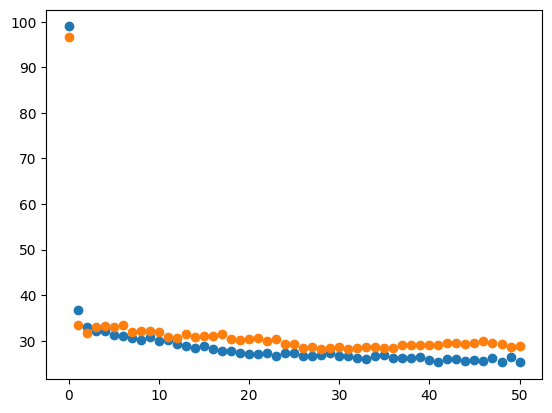

In [405]:
results = []

results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
for i in range(50):
    model.fit(x=train_input, y=train_output, epochs=100, verbose=0)
    results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
    print(results[-1])

fig, ax = plt.subplots()
ax.plot([r[0] for r in results], 'o')
ax.plot([r[1] for r in results], 'o')

print(results[-1][1])

plt.show()